# Face Recognition

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

## Librarys

In [59]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.image import resize
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
import PIL

from utils.inception_network import faceRecoModel
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import os
import sys
import random
import tensorflow as tf
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

<center><img src="images/pixel_comparison.png" style="width:380px;height:150px;"></center>
<caption><center> <u><b>Figure 1</b> </u></center></caption>

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## Encoding Face Images into a 128-Dimensional Vector

### Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, we'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation has been provided in the file `inception_blocks_v2.py`.  

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [3]:
# def load_dataset(dir):
#     import h5py
    
#     train_dataset = h5py.File(dir + 'train_face.h5', "r")
#     train_set_x_orig = np.array(train_dataset["train_set_x"][:])
#     train_set_y_orig = np.array(train_dataset["train_set_y"][:], dtype=str)
    
#     classes = np.array(train_dataset["list_classes"][:], dtype=str)

#     return train_set_x_orig, train_set_y_orig, classes


In [40]:
# train_x, train_y, classes = load_dataset(dir='../datasets/faces/')

# train_x = tf.image.resize(train_x, [96, 96])

# # Corrigindo o formato dos dados para 'channels_first'
# train_x = np.transpose(train_x, (0, 3, 1, 2))

# input_shape = train_x.shape[1:]
# print(input_shape)
# print(train_x.shape)

(3, 96, 96)
(426, 3, 96, 96)


In [65]:
target_size = (160, 160)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3, ), include_top=False)

In [66]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [67]:
database = {}
path_test = '../datasets/faces/test/'
database["danielle"] = img_to_encoding(path_test + "danielle.png", inception_model)
database["younes"] = img_to_encoding(path_test + "younes.jpg", inception_model)
database["tian"] = img_to_encoding(path_test + "tian.jpg", inception_model)
database["andrew"] = img_to_encoding(path_test + "andrew.jpg", inception_model)
database["kian"] = img_to_encoding(path_test + "kian.jpg", inception_model)
database["dan"] = img_to_encoding(path_test + "dan.jpg", inception_model)
database["sebastiano"] = img_to_encoding(path_test + "sebastiano.jpg", inception_model)
database["bertrand"] = img_to_encoding(path_test + "bertrand.jpg", inception_model)
database["kevin"] = img_to_encoding(path_test + "kevin.jpg", inception_model)
database["felix"] = img_to_encoding(path_test + "felix.jpg", inception_model)
database["benoit"] = img_to_encoding(path_test + "benoit.jpg", inception_model)
database["arnaud"] = img_to_encoding(path_test + "arnaud.jpg", inception_model)

ValueError: Improper number of dimensions to norm.

In [69]:
danielle = tf.keras.preprocessing.image.load_img(path_test + "danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img(path_test + "kian.jpg", target_size=(160, 160))

In [70]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

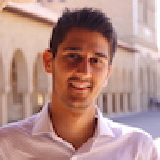

In [71]:
kian

In [72]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

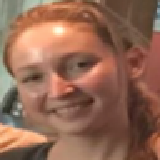

In [73]:
danielle

In [8]:
# # Obtendo todas as classes únicas de train_y e test_y combinados
# unique_labels = np.unique(np.concatenate((train_y, test_y.astype(str))))

# # Criando o mapeamento de rótulos para inteiros baseado em todas as classes únicas
# label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

# # Verificando o mapeamento
# print("Label to int mapping:", label_to_int)

# # Convertendo os rótulos do conjunto de treinamento para inteiros usando o mapeamento
# train_y_int = np.array([label_to_int[label] for label in train_y])

# # Convertendo rótulos do conjunto de teste diretamente para inteiros, pois já estão nesse formato
# test_y_int = np.array([label_to_int[label] for label in test_y.astype(str)])

# # Convertendo rótulos para one-hot encoding
# train_y_oh = tf.keras.utils.to_categorical(train_y_int, num_classes=len(unique_labels))
# test_y_oh = tf.keras.utils.to_categorical(test_y_int, num_classes=len(unique_labels))

# # Verificando as formas das matrizes resultantes
# print("train_y_oh shape:", train_y_oh.shape)
# print("test_y_oh shape:", test_y_oh.shape)


NameError: name 'unique_labels' is not defined

In [ ]:
model = faceRecoModel(input_shape)
model.summary()

Model: "FaceRecoModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 3, 96, 96) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, 9, 102,    │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 64, 48,    │     28,288 │ zero_padding2d_5… │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 64, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_83       │ (None, 64, 48,    │          0 │ bn1[0][0]         │
│ (Activation)        │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, 64, 50,    │          0 │ activation_83[0]… │
│ (ZeroPadding2D)     │ 47)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 24,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 64, 24,    │      4,160 │ max_pooling2d_15… │
│                     │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 64, 24,    │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (None, 64, 24,    │          0 │ bn2[0][0]         │
│ (Activation)        │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_55   │ (None, 64, 26,    │          0 │ activation_84[0]… │
│ (ZeroPadding2D)     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 192, 24,   │    110,784 │ zero_padding2d_5… │
│                     │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 192, 24,   │        768 │ conv3[0][0]       │
│ (BatchNormalizatio… │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_85       │ (None, 192, 24,   │          0 │ bn3[0][0]         │
│ (Activation)        │ 23)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_56   │ (None, 192, 26,   │          0 │ activation_85[0]… │
│ (ZeroPadding2D)     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 192, 12,   │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3_c… │ (None, 96, 12,    │     18,528 │ max_pooling2d_16

 Total params: 3,762,096 (14.35 MB)

 Trainable params: 3,752,784 (14.32 MB)

 Non-trainable params: 9,312 (36.38 KB)

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train
model.fit(train_x, train_y_int, epochs=10, batch_size=32)



Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.1680 - loss: 7.1774
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7541 - loss: 4.2269
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8544 - loss: 2.7796
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8365 - loss: 2.4009
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8321 - loss: 1.2916
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8013 - loss: 1.2174
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8329 - loss: 0.9503
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8447 - loss: 0.8663
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8258 - loss: 0.9393
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7581 - loss: 1.1088


ValueError: Input 0 of layer "FaceRecoModel" is incompatible with the layer: expected shape=(None, 3, 96, 96), found shape=(None, 96, 96, 96)

In [ ]:
# tf.keras.backend.set_image_data_format('channels_first')  # Para usar o formato channels_first

def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(96, 96))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)  # Se necessário, aplique o pré-processamento adequado aqui
    embedding = model.predict(img)
    return embedding / np.linalg.norm(embedding, ord=2)

InvalidArgumentError: Graph execution error:

Detected at node FaceRecoModel_1/conv1_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 84, in _run

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\darth\AppData\Local\Temp\ipykernel_10732\868288859.py", line 3, in <module>

  File "C:\Users\darth\AppData\Local\Temp\ipykernel_10732\697988351.py", line 8, in img_to_encoding

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 243, in call

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 233, in convolution_op

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\ops\nn.py", line 909, in conv

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 255, in conv

  File "d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 231, in _conv

input depth must be evenly divisible by filter depth: 3 vs 9
	 [[{{node FaceRecoModel_1/conv1_1/convolution}}]] [Op:__inference_one_step_on_data_distributed_135632]

In [ ]:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))

In [ ]:
# Avaliar o modelo
loss, accuracy = model.evaluate(test_x, test_y_oh)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# faceRecoModel.fit(train_x, train_y, epochs=10, batch_size=32)

AttributeError: 'function' object has no attribute 'fit'

In [ ]:
# from tensorflow.keras.models import model_from_json

# json_file = open('utils/keras_facenet_h5/model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.load_weights('utils/keras_facenet_h5/model.h5')

TypeError: Could not locate class 'Functional'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'Functional', 'config': {'name': 'inception_resnet_v1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 160, 160, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_1a_3x3', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_2a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_2a_3x3', 'inbound_nodes': [[['Conv2d_1a_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_2a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_2a_3x3_BatchNorm', 'inbound_nodes': [[['Conv2d_2a_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_2a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_2a_3x3_Activation', 'inbound_nodes': [[['Conv2d_2a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_2b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_2b_3x3', 'inbound_nodes': [[['Conv2d_2a_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_2b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_2b_3x3_BatchNorm', 'inbound_nodes': [[['Conv2d_2b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_2b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_2b_3x3_Activation', 'inbound_nodes': [[['Conv2d_2b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'MaxPooling2D', 'config': {'name': 'MaxPool_3a_3x3', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'name': 'MaxPool_3a_3x3', 'inbound_nodes': [[['Conv2d_2b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_3b_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_3b_1x1', 'inbound_nodes': [[['MaxPool_3a_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_3b_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_3b_1x1_BatchNorm', 'inbound_nodes': [[['Conv2d_3b_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_3b_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_3b_1x1_Activation', 'inbound_nodes': [[['Conv2d_3b_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_4a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_4a_3x3', 'inbound_nodes': [[['Conv2d_3b_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_4a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_4a_3x3_BatchNorm', 'inbound_nodes': [[['Conv2d_4a_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_4a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_4a_3x3_Activation', 'inbound_nodes': [[['Conv2d_4a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Conv2d_4b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Conv2d_4b_3x3', 'inbound_nodes': [[['Conv2d_4a_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Conv2d_4b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Conv2d_4b_3x3_BatchNorm', 'inbound_nodes': [[['Conv2d_4b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Conv2d_4b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Conv2d_4b_3x3_Activation', 'inbound_nodes': [[['Conv2d_4b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Conv2d_4b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Conv2d_4b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Conv2d_4b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_1_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0c_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0c_3x3', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0c_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block35_1_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Branch_2_Conv2d_0c_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Branch_2_Conv2d_0c_3x3_Activation', 'inbound_nodes': [[['Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block35_1_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block35_1_Concatenate', 'inbound_nodes': [[['Block35_1_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block35_1_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}], ['Block35_1_Branch_2_Conv2d_0c_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_1_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_1_Conv2d_1x1', 'inbound_nodes': [[['Block35_1_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block35_1_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [17, 17, 256], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.17}}, 'name': 'Block35_1_ScaleSum', 'inbound_nodes': [[['Conv2d_4b_3x3_Activation', 0, 0, {}], ['Block35_1_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_1_Activation', 'inbound_nodes': [[['Block35_1_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block35_1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_2_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0c_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0c_3x3', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0c_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block35_2_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Branch_2_Conv2d_0c_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Branch_2_Conv2d_0c_3x3_Activation', 'inbound_nodes': [[['Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block35_2_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block35_2_Concatenate', 'inbound_nodes': [[['Block35_2_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block35_2_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}], ['Block35_2_Branch_2_Conv2d_0c_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_2_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_2_Conv2d_1x1', 'inbound_nodes': [[['Block35_2_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block35_2_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [17, 17, 256], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.17}}, 'name': 'Block35_2_ScaleSum', 'inbound_nodes': [[['Block35_1_Activation', 0, 0, {}], ['Block35_2_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_2_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_2_Activation', 'inbound_nodes': [[['Block35_2_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_2_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_2_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block35_2_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_3_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0c_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0c_3x3', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0c_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block35_3_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Branch_2_Conv2d_0c_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Branch_2_Conv2d_0c_3x3_Activation', 'inbound_nodes': [[['Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block35_3_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block35_3_Concatenate', 'inbound_nodes': [[['Block35_3_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block35_3_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}], ['Block35_3_Branch_2_Conv2d_0c_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_3_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_3_Conv2d_1x1', 'inbound_nodes': [[['Block35_3_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block35_3_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [17, 17, 256], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.17}}, 'name': 'Block35_3_ScaleSum', 'inbound_nodes': [[['Block35_2_Activation', 0, 0, {}], ['Block35_3_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_3_Activation', 'inbound_nodes': [[['Block35_3_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block35_3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_4_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0c_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0c_3x3', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0c_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block35_4_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Branch_2_Conv2d_0c_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Branch_2_Conv2d_0c_3x3_Activation', 'inbound_nodes': [[['Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block35_4_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block35_4_Concatenate', 'inbound_nodes': [[['Block35_4_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block35_4_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}], ['Block35_4_Branch_2_Conv2d_0c_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_4_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_4_Conv2d_1x1', 'inbound_nodes': [[['Block35_4_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block35_4_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [17, 17, 256], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.17}}, 'name': 'Block35_4_ScaleSum', 'inbound_nodes': [[['Block35_3_Activation', 0, 0, {}], ['Block35_4_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_4_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_4_Activation', 'inbound_nodes': [[['Block35_4_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_4_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_4_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block35_4_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Block35_5_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0c_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0c_3x3', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0c_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block35_5_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Branch_2_Conv2d_0c_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Branch_2_Conv2d_0c_3x3_Activation', 'inbound_nodes': [[['Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block35_5_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block35_5_Concatenate', 'inbound_nodes': [[['Block35_5_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block35_5_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}], ['Block35_5_Branch_2_Conv2d_0c_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block35_5_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block35_5_Conv2d_1x1', 'inbound_nodes': [[['Block35_5_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block35_5_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [17, 17, 256], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.17}}, 'name': 'Block35_5_ScaleSum', 'inbound_nodes': [[['Block35_4_Activation', 0, 0, {}], ['Block35_5_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block35_5_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block35_5_Activation', 'inbound_nodes': [[['Block35_5_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block35_5_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3', 'inbound_nodes': [[['Block35_5_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_6a_Branch_0_Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'MaxPooling2D', 'config': {'name': 'Mixed_6a_Branch_2_MaxPool_1a_3x3', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'name': 'Mixed_6a_Branch_2_MaxPool_1a_3x3', 'inbound_nodes': [[['Block35_5_Activation', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Mixed_6a', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Mixed_6a', 'inbound_nodes': [[['Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation', 0, 0, {}], ['Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation', 0, 0, {}], ['Mixed_6a_Branch_2_MaxPool_1a_3x3', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Mixed_6a', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_1_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_1_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_1_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_1_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Mixed_6a', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_1_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_1_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_1_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_1_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_1_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_1_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_1_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_1_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_1_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_1_Concatenate', 'inbound_nodes': [[['Block17_1_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_1_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_1_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_1_Conv2d_1x1', 'inbound_nodes': [[['Block17_1_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_1_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_1_ScaleSum', 'inbound_nodes': [[['Mixed_6a', 0, 0, {}], ['Block17_1_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_1_Activation', 'inbound_nodes': [[['Block17_1_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_2_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_2_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_2_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_2_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_2_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_2_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_2_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_2_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_2_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_2_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_2_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_2_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_2_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_2_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_2_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_2_Concatenate', 'inbound_nodes': [[['Block17_2_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_2_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_2_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_2_Conv2d_1x1', 'inbound_nodes': [[['Block17_2_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_2_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_2_ScaleSum', 'inbound_nodes': [[['Block17_1_Activation', 0, 0, {}], ['Block17_2_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_2_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_2_Activation', 'inbound_nodes': [[['Block17_2_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_2_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_3_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_3_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_3_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_3_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_2_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_3_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_3_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_3_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_3_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_3_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_3_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_3_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_3_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_3_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_3_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_3_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_3_Concatenate', 'inbound_nodes': [[['Block17_3_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_3_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_3_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_3_Conv2d_1x1', 'inbound_nodes': [[['Block17_3_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_3_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_3_ScaleSum', 'inbound_nodes': [[['Block17_2_Activation', 0, 0, {}], ['Block17_3_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_3_Activation', 'inbound_nodes': [[['Block17_3_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_4_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_4_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_4_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_4_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_4_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_4_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_4_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_4_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_4_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_4_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_4_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_4_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_4_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_4_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_4_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_4_Concatenate', 'inbound_nodes': [[['Block17_4_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_4_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_4_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_4_Conv2d_1x1', 'inbound_nodes': [[['Block17_4_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_4_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_4_ScaleSum', 'inbound_nodes': [[['Block17_3_Activation', 0, 0, {}], ['Block17_4_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_4_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_4_Activation', 'inbound_nodes': [[['Block17_4_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_4_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_5_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_5_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_5_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_5_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_4_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_5_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_5_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_5_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_5_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_5_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_5_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_5_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_5_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_5_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_5_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_5_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_5_Concatenate', 'inbound_nodes': [[['Block17_5_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_5_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_5_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_5_Conv2d_1x1', 'inbound_nodes': [[['Block17_5_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_5_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_5_ScaleSum', 'inbound_nodes': [[['Block17_4_Activation', 0, 0, {}], ['Block17_5_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_5_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_5_Activation', 'inbound_nodes': [[['Block17_5_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_5_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_6_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_6_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_6_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_6_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_5_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_6_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_6_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_6_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_6_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_6_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_6_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_6_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_6_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_6_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_6_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_6_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_6_Concatenate', 'inbound_nodes': [[['Block17_6_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_6_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_6_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_6_Conv2d_1x1', 'inbound_nodes': [[['Block17_6_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_6_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_6_ScaleSum', 'inbound_nodes': [[['Block17_5_Activation', 0, 0, {}], ['Block17_6_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_6_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_6_Activation', 'inbound_nodes': [[['Block17_6_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_6_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_7_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_7_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_7_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_7_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_6_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_7_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_7_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_7_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_7_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_7_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_7_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_7_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_7_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_7_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_7_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_7_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_7_Concatenate', 'inbound_nodes': [[['Block17_7_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_7_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_7_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_7_Conv2d_1x1', 'inbound_nodes': [[['Block17_7_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_7_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_7_ScaleSum', 'inbound_nodes': [[['Block17_6_Activation', 0, 0, {}], ['Block17_7_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_7_Activation', 'inbound_nodes': [[['Block17_7_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_8_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_8_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_8_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_8_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_7_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_8_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_8_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_8_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_8_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_8_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_8_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_8_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_8_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_8_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_8_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_8_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_8_Concatenate', 'inbound_nodes': [[['Block17_8_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_8_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_8_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_8_Conv2d_1x1', 'inbound_nodes': [[['Block17_8_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_8_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_8_ScaleSum', 'inbound_nodes': [[['Block17_7_Activation', 0, 0, {}], ['Block17_8_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_8_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_8_Activation', 'inbound_nodes': [[['Block17_8_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_8_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_9_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_9_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_9_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_9_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_8_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_9_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_9_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_9_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_9_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_9_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_9_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_9_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_9_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_9_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_9_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_9_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_9_Concatenate', 'inbound_nodes': [[['Block17_9_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_9_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_9_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_9_Conv2d_1x1', 'inbound_nodes': [[['Block17_9_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_9_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_9_ScaleSum', 'inbound_nodes': [[['Block17_8_Activation', 0, 0, {}], ['Block17_9_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_9_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_9_Activation', 'inbound_nodes': [[['Block17_9_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_9_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_10_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0b_1x7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0b_1x7', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0b_1x7_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0b_1x7_BatchNorm', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0b_1x7', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0b_1x7_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_10_Branch_1_Conv2d_0b_1x7_Activation', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0b_1x7_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_10_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_10_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block17_9_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0c_7x1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0c_7x1', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0b_1x7_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_10_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_10_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block17_10_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0c_7x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block17_10_Branch_1_Conv2d_0c_7x1_BatchNorm', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0c_7x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_10_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_10_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block17_10_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_10_Branch_1_Conv2d_0c_7x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_10_Branch_1_Conv2d_0c_7x1_Activation', 'inbound_nodes': [[['Block17_10_Branch_1_Conv2d_0c_7x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block17_10_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block17_10_Concatenate', 'inbound_nodes': [[['Block17_10_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block17_10_Branch_1_Conv2d_0c_7x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block17_10_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 896, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block17_10_Conv2d_1x1', 'inbound_nodes': [[['Block17_10_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block17_10_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [8, 8, 896], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.1}}, 'name': 'Block17_10_ScaleSum', 'inbound_nodes': [[['Block17_9_Activation', 0, 0, {}], ['Block17_10_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block17_10_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block17_10_Activation', 'inbound_nodes': [[['Block17_10_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_10_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_10_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block17_10_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0b_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3', 'inbound_nodes': [[['Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_1_Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_1a_3x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation', 'inbound_nodes': [[['Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'MaxPooling2D', 'config': {'name': 'Mixed_7a_Branch_3_MaxPool_1a_3x3', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'name': 'Mixed_7a_Branch_3_MaxPool_1a_3x3', 'inbound_nodes': [[['Block17_10_Activation', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Mixed_7a', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Mixed_7a', 'inbound_nodes': [[['Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation', 0, 0, {}], ['Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation', 0, 0, {}], ['Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation', 0, 0, {}], ['Mixed_7a_Branch_3_MaxPool_1a_3x3', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Mixed_7a', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_1_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_1_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_1_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_1_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Mixed_7a', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_1_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_1_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_1_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_1_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_1_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_1_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_1_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_1_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_1_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_1_Concatenate', 'inbound_nodes': [[['Block8_1_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_1_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_1_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_1_Conv2d_1x1', 'inbound_nodes': [[['Block8_1_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_1_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.2}}, 'name': 'Block8_1_ScaleSum', 'inbound_nodes': [[['Mixed_7a', 0, 0, {}], ['Block8_1_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_1_Activation', 'inbound_nodes': [[['Block8_1_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block8_1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_2_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_2_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_2_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_2_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block8_1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_2_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_2_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_2_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_2_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_2_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_2_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_2_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_2_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_2_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_2_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_2_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_2_Concatenate', 'inbound_nodes': [[['Block8_2_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_2_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_2_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_2_Conv2d_1x1', 'inbound_nodes': [[['Block8_2_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_2_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.2}}, 'name': 'Block8_2_ScaleSum', 'inbound_nodes': [[['Block8_1_Activation', 0, 0, {}], ['Block8_2_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_2_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_2_Activation', 'inbound_nodes': [[['Block8_2_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block8_2_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_3_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_3_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_3_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_3_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block8_2_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_3_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_3_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_3_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_3_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_3_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_3_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_3_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_3_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_3_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_3_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_3_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_3_Concatenate', 'inbound_nodes': [[['Block8_3_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_3_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_3_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_3_Conv2d_1x1', 'inbound_nodes': [[['Block8_3_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_3_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.2}}, 'name': 'Block8_3_ScaleSum', 'inbound_nodes': [[['Block8_2_Activation', 0, 0, {}], ['Block8_3_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_3_Activation', 'inbound_nodes': [[['Block8_3_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block8_3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_4_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_4_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_4_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_4_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block8_3_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_4_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_4_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_4_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_4_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_4_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_4_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_4_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_4_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_4_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_4_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_4_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_4_Concatenate', 'inbound_nodes': [[['Block8_4_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_4_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_4_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_4_Conv2d_1x1', 'inbound_nodes': [[['Block8_4_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_4_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.2}}, 'name': 'Block8_4_ScaleSum', 'inbound_nodes': [[['Block8_3_Activation', 0, 0, {}], ['Block8_4_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_4_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_4_Activation', 'inbound_nodes': [[['Block8_4_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block8_4_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_5_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_5_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_5_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_5_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block8_4_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_5_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_5_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_5_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_5_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_5_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_5_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_5_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_5_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_5_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_5_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_5_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_5_Concatenate', 'inbound_nodes': [[['Block8_5_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_5_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_5_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_5_Conv2d_1x1', 'inbound_nodes': [[['Block8_5_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_5_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 0.2}}, 'name': 'Block8_5_ScaleSum', 'inbound_nodes': [[['Block8_4_Activation', 0, 0, {}], ['Block8_5_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_5_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_5_Activation', 'inbound_nodes': [[['Block8_5_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0a_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0a_1x1', 'inbound_nodes': [[['Block8_5_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0a_1x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0a_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_6_Branch_1_Conv2d_0a_1x1_Activation', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0b_1x3', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0b_1x3', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0a_1x1_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0b_1x3', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0b_1x3_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_6_Branch_1_Conv2d_0b_1x3_Activation', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_6_Branch_0_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_6_Branch_0_Conv2d_1x1', 'inbound_nodes': [[['Block8_5_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0c_3x1', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0c_3x1', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0b_1x3_Activation', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_6_Branch_0_Conv2d_1x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_6_Branch_0_Conv2d_1x1_BatchNorm', 'inbound_nodes': [[['Block8_6_Branch_0_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0c_3x1', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_6_Branch_0_Conv2d_1x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_6_Branch_0_Conv2d_1x1_Activation', 'inbound_nodes': [[['Block8_6_Branch_0_Conv2d_1x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Activation', 'config': {'name': 'Block8_6_Branch_1_Conv2d_0c_3x1_Activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'name': 'Block8_6_Branch_1_Conv2d_0c_3x1_Activation', 'inbound_nodes': [[['Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm', 0, 0, {}]]]}, {'class_name': 'Concatenate', 'config': {'name': 'Block8_6_Concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'name': 'Block8_6_Concatenate', 'inbound_nodes': [[['Block8_6_Branch_0_Conv2d_1x1_Activation', 0, 0, {}], ['Block8_6_Branch_1_Conv2d_0c_3x1_Activation', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'Block8_6_Conv2d_1x1', 'trainable': True, 'dtype': 'float32', 'filters': 1792, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Block8_6_Conv2d_1x1', 'inbound_nodes': [[['Block8_6_Concatenate', 0, 0, {}]]]}, {'class_name': 'Lambda', 'config': {'name': 'Block8_6_ScaleSum', 'trainable': True, 'dtype': 'float32', 'function': ['4wIAAAAAAAAAAgAAAAMAAABTAAAAcxQAAAB8AGQBGQB8AGQCGQB8ARQAFwBTACkDTukAAAAA6QEA\nAACpACkC2gZpbnB1dHPaBXNjYWxlcgMAAAByAwAAAPobLi4vY29kZS9mYWNlbmV0X2tlcmFzX3Yx\nLnB52gg8bGFtYmRhPloAAADzAAAAAA==\n', None, None], 'function_type': 'lambda', 'module': 'tensorflow.python.keras.layers.core', 'output_shape': [3, 3, 1792], 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {'scale': 1.0}}, 'name': 'Block8_6_ScaleSum', 'inbound_nodes': [[['Block8_5_Activation', 0, 0, {}], ['Block8_6_Conv2d_1x1', 0, 0, {}]]]}, {'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'AvgPool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'name': 'AvgPool', 'inbound_nodes': [[['Block8_6_ScaleSum', 0, 0, {}]]]}, {'class_name': 'Dropout', 'config': {'name': 'Dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.19999999999999996, 'noise_shape': None, 'seed': None}, 'name': 'Dropout', 'inbound_nodes': [[['AvgPool', 0, 0, {}]]]}, {'class_name': 'Dense', 'config': {'name': 'Bottleneck', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Bottleneck', 'inbound_nodes': [[['Dropout', 0, 0, {}]]]}, {'class_name': 'BatchNormalization', 'config': {'name': 'Bottleneck_BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.995, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'name': 'Bottleneck_BatchNorm', 'inbound_nodes': [[['Bottleneck', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['Bottleneck_BatchNorm', 0, 0]]}, 'keras_version': '2.4.0', 'backend': 'tensorflow'}

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. Then we can use the encodings to compare two face images as follows:

<center><img src="images/distance_kiank.png\" style="width:680px;height:250px;"></center>
<caption><center> <u>  <b>Figure 2:</b> <br> </u> By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
<center><img src="images/triplet_comparison.png" style="width:280px;height:150px;"><br></center>
<caption><center> <u> <b>Figure 3: </b> <br> </u> In the next section,  you'll call the pictures from left to right: Anchor (A), Positive (P), Negative (N)</center></caption>

In [ ]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [ ]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)